<a href="https://colab.research.google.com/github/yogesh1q2w/PlanningGridWorld/blob/master/GridWorld_Deterministic_Model_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function, unicode_literals 
import tensorflow as tf
from matplotlib import colors
from collections import defaultdict
import random
import glob
# import tensorflow.contrib.slim as slim
import os
import re
from tensorflow import keras
tf.compat.v1.enable_eager_execution()
tf.compat.v1.enable_v2_tensorshape()

In [0]:
def printgrid(data):
  # create discrete colormap
  cmap = colors.ListedColormap(['red', 'blue','white','black'])
  bounds = [0,1,2,3,4]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  fig, ax = plt.subplots()
  ax.imshow(data, cmap=cmap, norm=norm)

  # draw gridlines
  ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()

def matfromfile(file):
    with open(file,'r') as f:
        s = []
        t = []
        r = f.read()
        f.close()
        l = 0
        tt = 0
        for j in r:
            if(j == '\n'):
                s.append(t)
                t = []
                tt = 0
                l += 1
            else:
                if j == '2':
                    end = np.array([l,tt])
                t.append(int(j))
                tt += 1
        return np.array(s),end


In [0]:
num_actions = 4
class GridEnv:
    def __init__(self,file, det=True):
        self.gridfile = file
        self.determ = det
        self.grid, self.goal = matfromfile(self.gridfile) 
        self.nstates = np.size(self.grid)
        self.nactions = 4
        self.actions = ['l','r','u','d']
        self.nrows = np.shape(self.grid)[0]
        self.ncols = np.shape(self.grid)[1]
        self.End = False
        self.start = [np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)]
        while(self._gridval(self.start) == 0 or self._isEnd(self.start)):
          self.start = [np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)]
        self.curr_state = self.start
        
    def _gridval(self,state):
        return self.grid[state[0], state[1]]
        
    def _reward(self,state):
        
        if self.grid[state[0],state[1]] == 2:
            return +5.
        elif self._gridval(state) == 0:   
            return -2.
        else:
            return -1.
        
    def _isEnd(self,state):
        if (self.grid[state[0], state[1]] == 2):
          self.End = True
        else:
          self.End = False
        return self.End
        
    def _nonDeterminsticTrans(self,action):
        if action == 'u':
            return np.random.choice(['u','l','r'], p = [0.8,0.1,0.1])
        
        if action == 'd':
            return np.random.choice(['d','l','r'], p = [0.8,0.1,0.1])
        
        if action == 'l':
            return np.random.choice(['l','u','d'], p = [0.8,0.1,0.1])
        
        if action == 'r':
            return np.random.choice(['r','u','d'], p = [0.8,0.1,0.1])
        
    def sense(self,k):
        s = self.curr_state
        up = np.flip(self.grid[max(0,s[0]-k):s[0],s[1]])
        down = self.grid[s[0]+1:min(self.nrows,s[0]+k+1),s[1]]
        left = np.flip(self.grid[s[0],max(0,s[1]-k):s[1]])
        right = self.grid[s[0],s[1]+1:min(self.ncols,s[1]+k+1)]
        
        if(np.size(up) > 0):
            zr = np.where(up == 0)
            if(np.size(zr) == 0):
                filtup = up
            else:
                filtup = up[0:np.amin(zr)]
        else:
            filtup = np.array([])
            
        if(np.size(down) > 0):
            zr = np.where(down == 0)
            if(np.size(zr) == 0):
                filtdown = down
            else:
                filtdown = down[0:np.amin(zr)]
        else:
            filtdown = np.array([])
            
        if(np.size(left) > 0):
            zr = np.where(left == 0)
            if(np.size(zr) == 0):
                filtleft = left
            else:
                filtleft = left[0:np.amin(zr)]
        else:
            filtleft = np.array([])
            
        if(np.size(right) > 0):
            zr = np.where(right == 0)
            if(np.size(zr) == 0):
                filtright = right
            else:
                filtright = right[0:np.amin(zr)]
        else:
            filtright = np.array([])
            
            
        return np.array([filtup,filtdown,filtleft,filtright])
        
    def transition(self, action):
        if self.determ:
            if action == 'u':
                nextState = self.curr_state + np.array([-1,0])
            elif action == 'd':
                nextState = self.curr_state + np.array([1,0])
            elif action == 'l':
                nextState = self.curr_state + np.array([0,-1])
            elif action == 'r':
                nextState = self.curr_state + np.array([0,1])
                
        else:
            action = self._nonDeterminsticTrans(action)
            self.determ = True
            nextState,_,_ = self.transition(action)
            self.determ = False
            
#         print(nextState)
        if (nextState[0] >= 0) and (nextState[0] < self.nrows):
            if (nextState[1] >= 0) and (nextState[1] < self.ncols):
              if (self._gridval(nextState) != 0):
                self.curr_state = nextState
                return nextState,self._reward(nextState),self._isEnd(nextState)
              else:
                return self.curr_state,self._reward(nextState),self._isEnd(self.curr_state)
        
        return self.curr_state, self._reward(self.curr_state), self._isEnd(self.curr_state)
             
    def reset(self):
        self.start = np.array([np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)])
        while(self._gridval(self.start) == 0 or self._isEnd(self.start)):
          # print(self.start)
          self.start = np.array([np.random.randint(0,self.nrows),np.random.randint(0,self.ncols)])
        self.curr_state = self.start
        self.End = False
            

In [0]:
class exp_buff():
  def __init__(self, buffer_size = 50000):
    self.buffer = []
    self.buffer_size = buffer_size

  def add(self, experience):
    while (len(self.buffer) >= self.buffer_size):
      self.buffer.pop(0)
    self.buffer.append(experience)

  def sample(self, size):
    return random.sample(self.buffer,size)

  def num_samples(self):
    return len(self.buffer)

In [0]:
class DSU:

  def __init__(self, nrow, ncol):
    self.parent = {}
    self.rank = {}
    for i in range(0,nrow):
      for j in range(0,ncol):
        self.parent[string([i,j])] = string([i,j])
        self.rank[string([i,j])] = 0
  
  def find(self, elt):
    if self.parent[elt] != elt:
      self.parent[elt] = self.find(self.parent[elt])

    return self.parent[elt]

  def union(self,eltx, elty):
    xroot = self.find(eltx)
    yroot = self.find(elty)
    
    if (self.rank[xroot] < self.rank[yroot]):
      self.parent[xroot] = yroot
    elif (self.rank[xroot] > self.rank[yroot]):
      self.parent[yroot] = xroot
    else:
      self.parent[yroot] = xroot
      self.rank[xroot]+=1

  def sameComp(self,x,y):
    return self.find(x) == self.find(y)

In [0]:
def string(s):
  return '(' + str(s[0]) + ',' + str(s[1]) + ')'

def array(s):
  s = s[1:-1]
  l = s.strip().split(',')
  return np.array([int(l[0]), int(l[1])])

def norm_array(s):
  s = s[1:-1]
  l = s.strip().split(',')
  return np.array([int(l[0])/nrow, int(l[1])/ncol])

class SimpleAgent:
    
    def __init__(self, sense, goal):
        self.senseCap = sense
        self.actions = [0,1,2,3]
        self.actd = {0:'u',1:'d',2:'l',3:'r'}
        self.actrev = {'u':0,'d':1,'l':2,'r':3}
        self.model = np.ones((nrow,ncol))*3
        self.comps = DSU(nrow,ncol)
        self.goal = goal
        # print(goal)
        self.model[goal[0],goal[1]] = 2
        self.planbit = False                                                    #store if you are planning in current state
        
        self.lr = 0.2
        self.epsilon = 0.1
        self.gamma = 0.9
        self.planeps = 0.9
        self.BATCH_SIZE = 64
        self.tau = 0.08

        self.prim_DQN = keras.Sequential([
                        keras.layers.Dense(30,
                                           activation = 'relu',
                                           kernel_initializer = keras.initializers.he_normal(), input_shape = (2,)),
                        keras.layers.Dense(30,
                                           activation = 'relu',
                                           kernel_initializer = keras.initializers.he_normal()),
                        keras.layers.Dense(num_actions)
])

        self.targ_DQN = keras.Sequential([
                                keras.layers.Dense(30,
                                                  activation = 'relu',
                                                  kernel_initializer = keras.initializers.he_normal(),input_shape = (2,)),
                                keras.layers.Dense(30,
                                                  activation = 'relu',
                                                  kernel_initializer = keras.initializers.he_normal()),
                                keras.layers.Dense(num_actions)
        ])

        self.prim_DQN.compile(optimizer = keras.optimizers.Adam(), loss = 'mse')
        self.pseudo_rwd = +2                                                    #change this parameter for tuning bonuses

    def train(self, memory, targ_update):
      if memory.num_samples() < self.BATCH_SIZE*3:
        return 0

      batch = memory.sample(self.BATCH_SIZE)
      states = np.array([val[0] for val in batch])
      actions = np.array([val[1] for val in batch])
      rewards = np.array([val[2] for val in batch])
      next_states = np.array([val[3] for val in batch])

      prim_qt = self.prim_DQN(states)
      prim_qtp1 = self.prim_DQN(next_states)
      targ_q = prim_qt.numpy()
      updates = rewards
      valid_idxs = np.array([val[4] for val in batch])
      batch_idxs = np.arange(self.BATCH_SIZE)
      
      if targ_update:
        prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis = 1)
        q_from_targ = self.targ_DQN(next_states)
        updates[valid_idxs] += self.gamma * q_from_targ.numpy()[batch_idxs[valid_idxs], prim_action_tp1[valid_idxs]]
      else:
        updates[valid_idxs] += self.gamma * np.amax(prim_qtp1.numpy()[valid_idxs,:], axis = 1)

      targ_q[batch_idxs, actions] = updates
      loss = self.prim_DQN.train_on_batch(states, targ_q)
      if targ_update:
        for t,e in zip(self.targ_DQN.trainable_variables, self.prim_DQN.trainable_variables):
          t.assign(t * (1-self.tau)+ e * self.tau)
      
      return loss


    def explore(self,state,senseRes):
      if np.random.rand() < self.epsilon:
          safeExps = []
          for i in range(0,4):
            if len(senseRes[i] > 0):
              safeExps.append(i)
                  
          action = np.random.choice(safeExps)
          acList = [self.actd[action]]
      else:
          action = np.argmax(self.prim_DQN(norm_array(state).reshape(1,-1)))
          acList = [self.actd[action]]
      
      return acList

    def plan(self, state, senseRes):
      strgoal = string(self.goal)
      if self.comps.sameComp(state, strgoal):
        acList = self.BFS(array(state),self.goal)
      else:
        acList = self.borderBFS(array(state))
        self.planbit = True

      return acList

    def pick_action(self, state, senseRes):
      
        if np.random.rand() < self.planeps and (not self.isBorder(array(state)) or self.comps.sameComp(state,string(self.goal))):
          act1 = self.plan(state,senseRes)
          return act1

        else:
          act1 = self.explore(state,senseRes)
          return act1
          

    def BFS(self, source, goal):
      q = []
      q.append(source)
      pred = {}
      vis = defaultdict(lambda:0)
      vis[string(source)] = 1
      flagval = True
      while (not len(q) == 0 and flagval):
        u = q.pop(0)
        for i in [[-1,0],[1,0],[0,-1],[0,1]]:
          if not flagval:
            break
          coord = u+np.array(i)
          if(coord[0] >= 0 and coord[0] < nrow and coord[1] >=0 and coord[1] < ncol):
            if((self.model[coord[0],coord[1]] == 1 or self.model[coord[0],coord[1]] == 2)  and vis[string(coord)] == 0):
              q.append(coord)
              pred[string(coord)] = u
              vis[string(coord)] = 1

              if np.array_equal(coord,goal):
                flagval = False
                break
      
      acList = []
      v = goal 

      actionmap = {'(1,0)':'d','(-1,0)':'u','(0,1)':'r','(0,-1)':'l'}

      while(not np.array_equal(v,source)):
        acList = [actionmap[string(v-pred[string(v)])]] + acList
        v = pred[string(v)]

      return acList
      
    def isBorder(self,state):
      for i in [[-1,0],[1,0],[0,-1],[0,1]]:
          coord = state+np.array(i)
          if(coord[0] >= 0 and coord[0] < nrow and coord[1] >=0 and coord[1] < ncol):
            if(self.model[coord[0],coord[1]] == 3):
              return True
      return False

    def borderBFS(self, source):
      border_states = []
      q = []
      q.append(source)
      pred = {}
      vis = defaultdict(lambda:0)
      vis[string(source)] = 1
      flagval = True
      if(self.isBorder(source)):
        border_states.append(source)
      while (not len(q) == 0 and flagval):
        u = q.pop(0)
        for i in [[-1,0],[1,0],[0,-1],[0,1]]:
          if not flagval:
            break
          coord = u+np.array(i)
          if(coord[0] >= 0 and coord[0] < nrow and coord[1] >=0 and coord[1] < ncol):
            if((self.model[coord[0],coord[1]] == 1 or self.model[coord[0],coord[1]] == 2) and vis[string(coord)] == 0):
              q.append(coord)
              if(self.isBorder(coord)):
                border_states.append(coord)
              pred[string(coord)] = u
              vis[string(coord)] = 1

              if np.array_equal(coord,self.goal):
                border_states = [self.goal]
                flagval = False
                break
      
      acList = []
      # print(border_states)
      v = border_states[np.random.randint(0,len(border_states))] 

      actionmap = {'(1,0)':'d','(-1,0)':'u','(0,1)':'r','(0,-1)':'l'}

      while(not np.array_equal(v,source)):
        acList = [actionmap[string(v-pred[string(v)])]] + acList
        v = pred[string(v)]

      return acList

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re


1000

Planning and Learning-----DQN-----1000X1000 gridworld-----deterministic
Loss =  0.0008068770722151192
Map after episode#  0 . 0


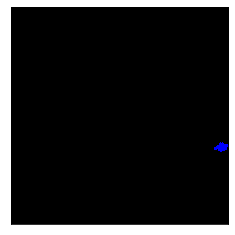

Loss =  4.727521360411833e-06
Map after episode#  0 . 1


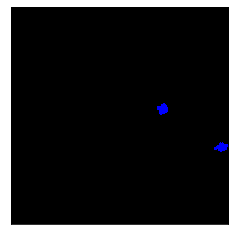

Loss =  4.885867301492591e-07
Map after episode#  0 . 2


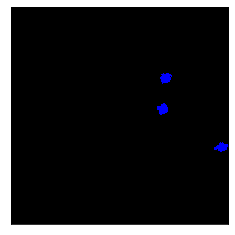

Loss =  5.954453439578085e-07
Map after episode#  0 . 3


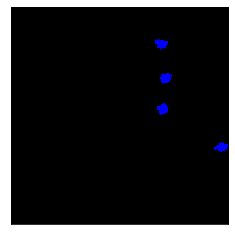

Loss =  5.591705732395696e-07
Map after episode#  0 . 4


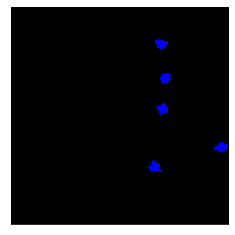

Loss =  3.6248761263044284e-07
Map after episode#  0 . 5


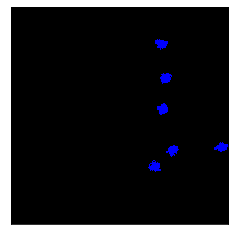

Loss =  6.043382052745887e-07
Map after episode#  0 . 6


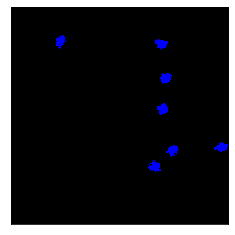

Loss =  6.152340644670966e-07
Map after episode#  0 . 7


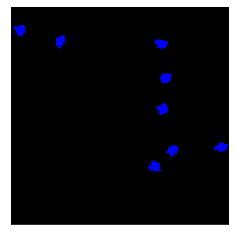

Loss =  3.625109350298157e-07
Map after episode#  0 . 8


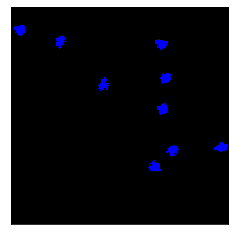

Loss =  2.772312765367556e-07
Map after episode#  0 . 9


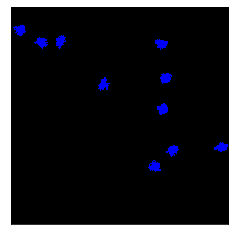

Loss =  2.689613735890468e-07
Map after episode#  0 . 10


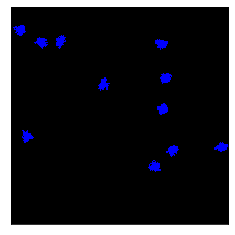

Loss =  7.1055468614839544e-06
Map after episode#  0 . 11


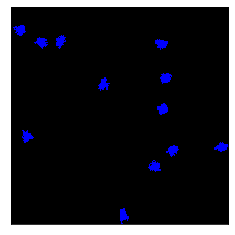

Loss =  7.642233888338006e-06
Map after episode#  0 . 12


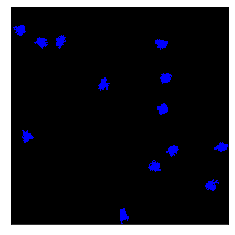

Loss =  7.0834595623182986e-06
Map after episode#  0 . 13


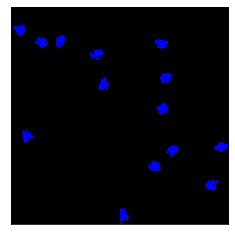

Loss =  8.651647767462263e-06
Map after episode#  0 . 14


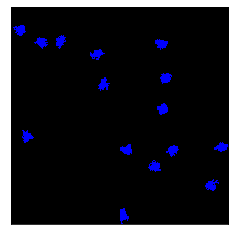

Loss =  7.108584375631255e-06
Map after episode#  0 . 15


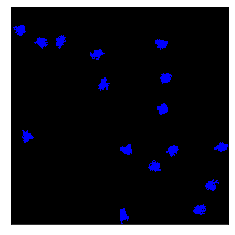

Loss =  1.5559533858115916e-06
Map after episode#  0 . 16


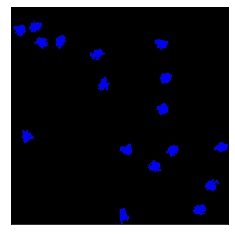

Loss =  1.469710650860999e-07
Map after episode#  0 . 17


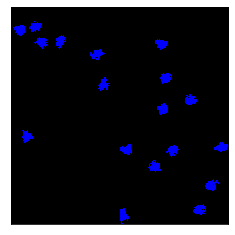

Loss =  1.8529835445324342e-07
Map after episode#  0 . 18


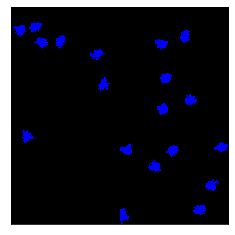

Loss =  1.2753515609664815e-07
Map after episode#  0 . 19


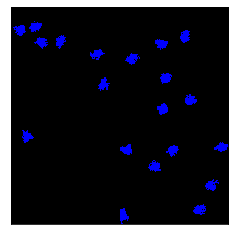

Loss =  9.974672578286065e-08
Map after episode#  0 . 20


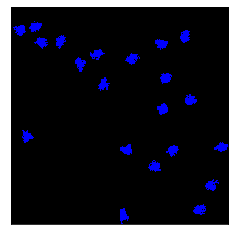

Loss =  1.0776934212068896e-07
Map after episode#  0 . 21


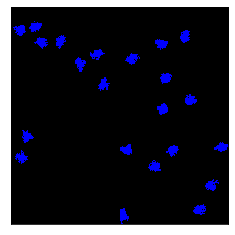

Loss =  1.1417286832632877e-07
Map after episode#  0 . 22


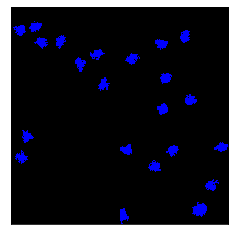

Loss =  1.2306305180336831e-07
Map after episode#  0 . 23


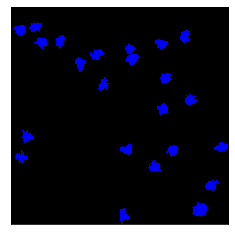

Loss =  1.0140610488642167e-07
Map after episode#  0 . 24


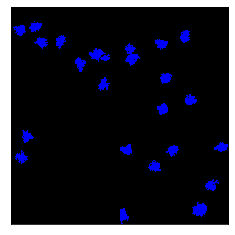

Loss =  9.090604450023411e-08
Map after episode#  0 . 25


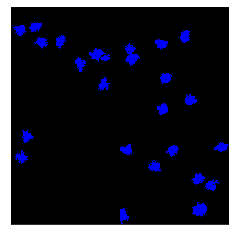

Loss =  8.40533921266812e-08
Map after episode#  0 . 26


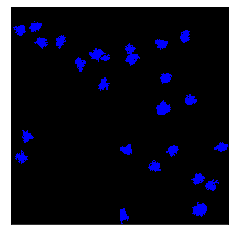

Loss =  7.447748183030304e-08
Map after episode#  0 . 27


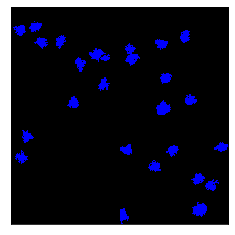

Loss =  7.744321215913292e-08
Map after episode#  0 . 28


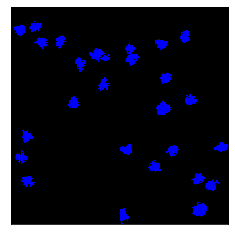

Loss =  1.566319996523394e-07
Map after episode#  0 . 29


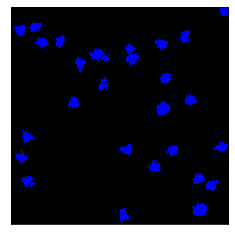

Loss =  0.00013598221521004083
Map after episode#  0 . 30


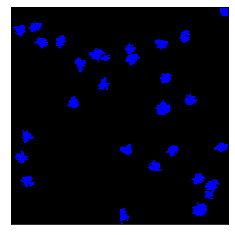

Loss =  0.00016887218906512475
Map after episode#  0 . 31


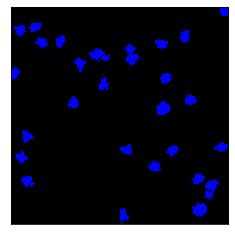

Loss =  0.000161525198894498
Map after episode#  0 . 32


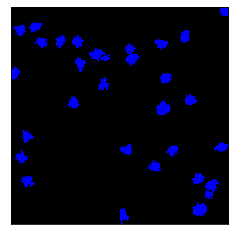

Loss =  0.00013880789023679223
Map after episode#  0 . 33


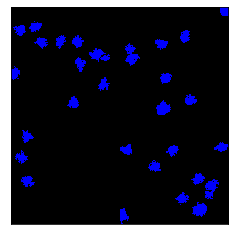

Loss =  0.00014065850604648918
Map after episode#  0 . 34


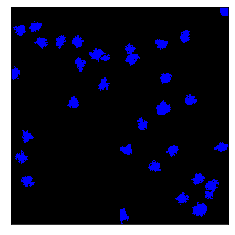

Loss =  4.6692256382468315e-06
Map after episode#  0 . 35


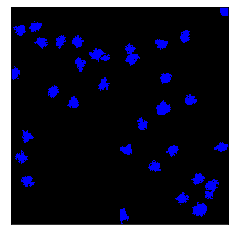

Loss =  2.99508872109703e-06
Map after episode#  0 . 36


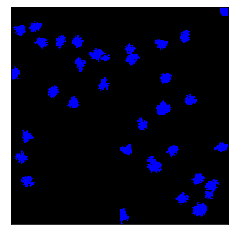

Loss =  3.453921529110749e-08
Map after episode#  0 . 37


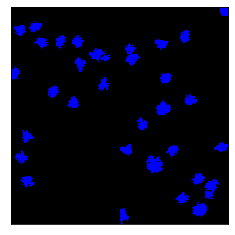

Loss =  2.8957882786759194e-08
Map after episode#  0 . 38


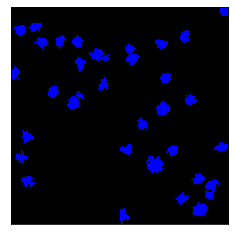

Loss =  2.5431315738727102e-08
Map after episode#  0 . 39


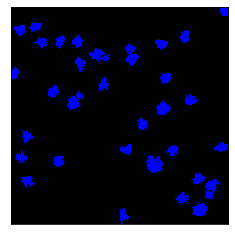

Loss =  2.7594629691033014e-08
Map after episode#  0 . 40


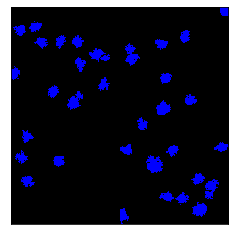

Loss =  3.2129166557524096e-08
Map after episode#  0 . 41


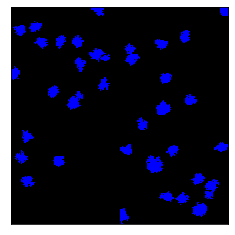

Loss =  2.852211711088809e-08
Map after episode#  0 . 42


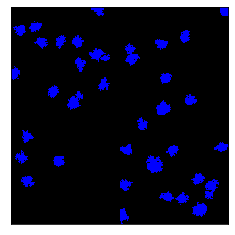

Loss =  2.967432029653372e-08
Map after episode#  0 . 43


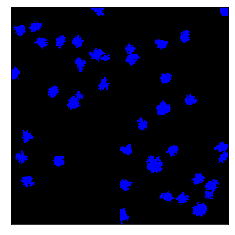

Loss =  2.4667907159510637e-08
Map after episode#  0 . 44


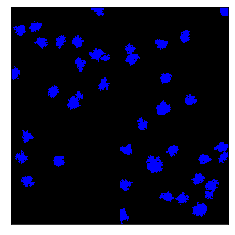

Loss =  2.4073520299669725e-08
Map after episode#  0 . 45


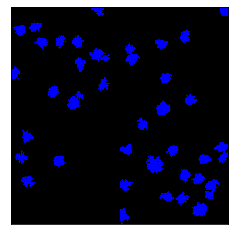

Loss =  2.6582504666922414e-08
Map after episode#  0 . 46


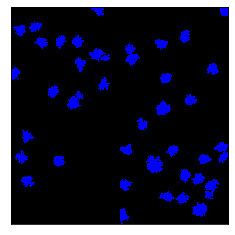

Loss =  2.4566552717031906e-08
Map after episode#  0 . 47


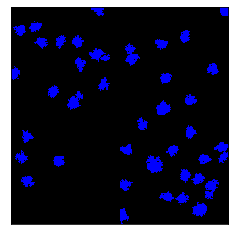

Loss =  2.225294107361382e-08
Map after episode#  0 . 48


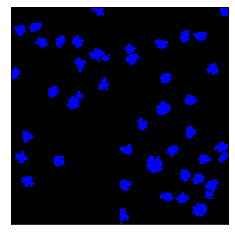

Loss =  1.9289527236840663e-08
Map after episode#  0 . 49


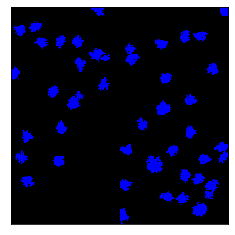

Loss =  1.9370594887351452e-08
Map after episode#  0 . 50


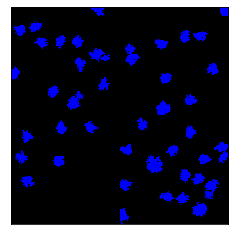

Loss =  1.8297748213521344e-08
Map after episode#  0 . 51


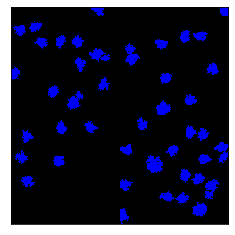

Loss =  2.081842655415868e-08
Map after episode#  0 . 52


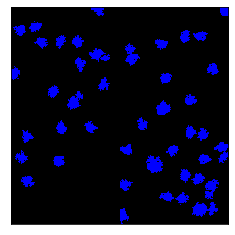

Loss =  1.9274390565312154e-08
Map after episode#  0 . 53


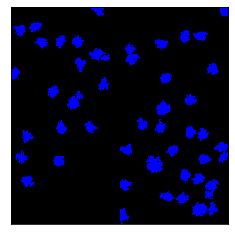

Loss =  1.8377766771791364e-08
Map after episode#  0 . 54


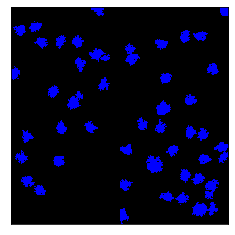

Loss =  1.9178470071843223e-08
Map after episode#  0 . 55


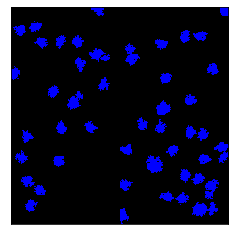

Loss =  1.8633640229659247e-08
Map after episode#  0 . 56


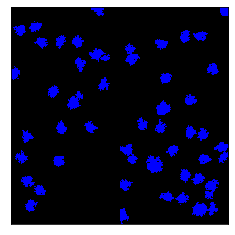

Loss =  2.0328183934893012e-08
Map after episode#  0 . 57


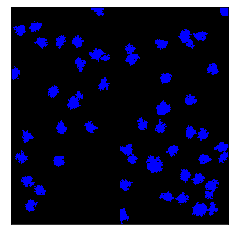

Loss =  1.88376742252764e-08
Map after episode#  0 . 58


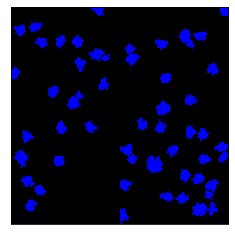

Loss =  1.6424949668387564e-08
Map after episode#  0 . 59


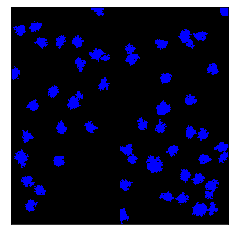

Loss =  1.7000652546354015e-08
Map after episode#  0 . 60


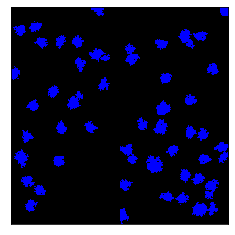

Loss =  1.4096977735850375e-08
Map after episode#  0 . 61


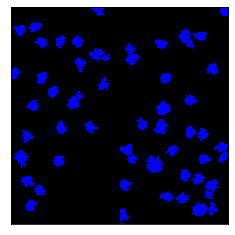

Loss =  1.3414861622862574e-08
Map after episode#  0 . 62


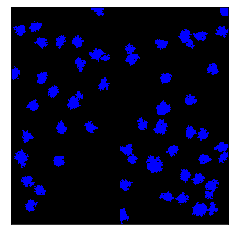

Loss =  1.3883825785863708e-08
Map after episode#  0 . 63


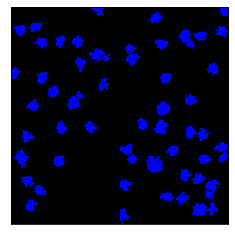

Loss =  1.4428435721518497e-08
Map after episode#  0 . 64


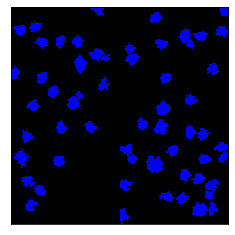

Loss =  4.609622083030037e-06
Map after episode#  0 . 65


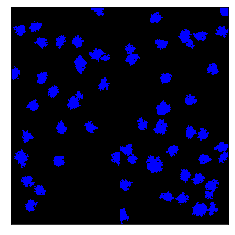

Loss =  5.861944800146345e-06
Map after episode#  0 . 66


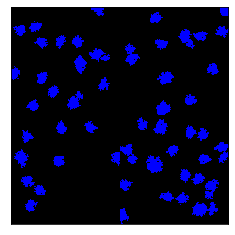

Loss =  4.9978675050795874e-06
Map after episode#  0 . 67


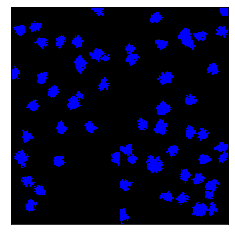

Loss =  4.221070985176862e-06
Map after episode#  0 . 68


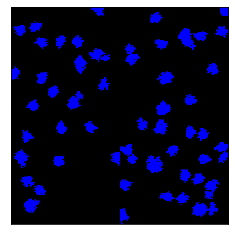

Loss =  5.007778898322311e-06
Map after episode#  0 . 69


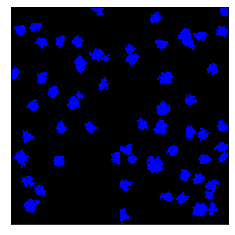

Loss =  1.6732824633712598e-06
Map after episode#  0 . 70


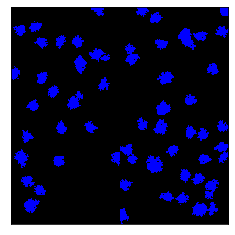

Loss =  1.2186194452593429e-08
Map after episode#  0 . 71


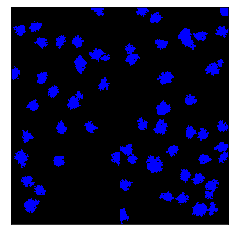

Loss =  1.2059426668872503e-08
Map after episode#  0 . 72


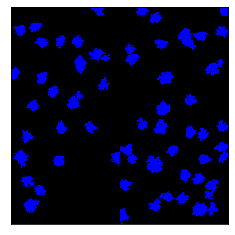

Loss =  1.0593547518957605e-08
Map after episode#  0 . 73


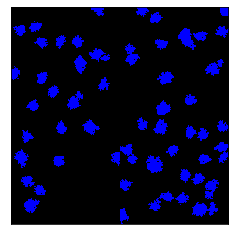

Loss =  9.779255711990387e-09
Map after episode#  0 . 74


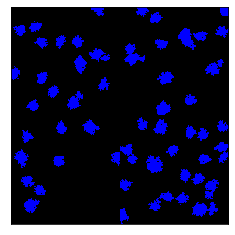

Loss =  1.104519041209869e-08
Map after episode#  0 . 75


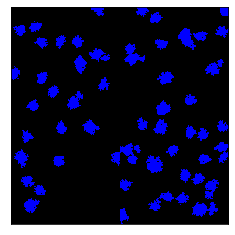

Loss =  1.1867582120575959e-08
Map after episode#  0 . 76


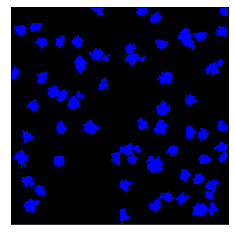

Loss =  9.631954350814704e-09
Map after episode#  0 . 77


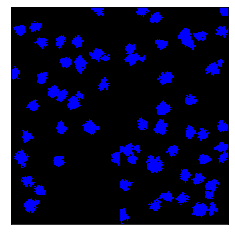

Loss =  9.792826638362908e-09
Map after episode#  0 . 78


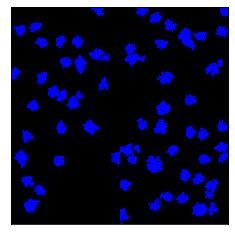

Loss =  9.015328792802049e-09
Map after episode#  0 . 79


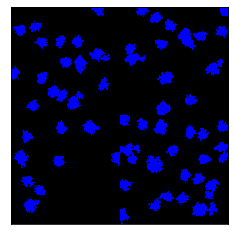

Loss =  5.770921204953193e-06
Map after episode#  0 . 80


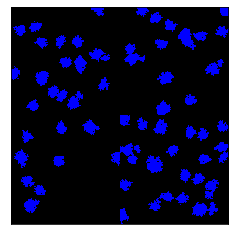

Loss =  6.131770877831073e-06
Map after episode#  0 . 81


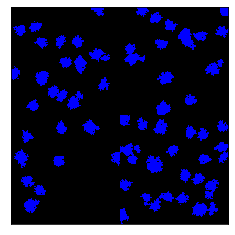

Loss =  6.527985677862827e-06
Map after episode#  0 . 82


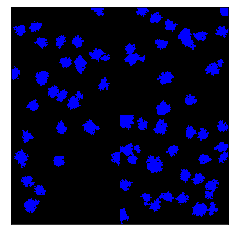

Loss =  3.291156863652536e-06
Map after episode#  0 . 83


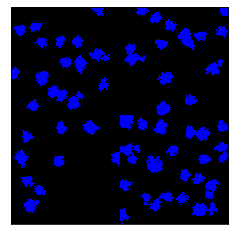

Loss =  4.513982780973579e-06
Map after episode#  0 . 84


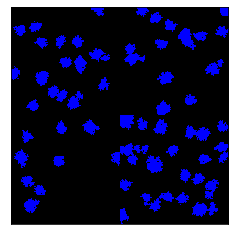

Loss =  7.226772143542165e-09
Map after episode#  0 . 85


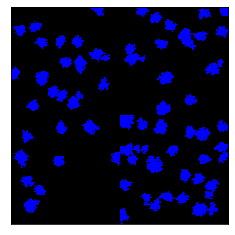

Loss =  1.031727182802816e-08
Map after episode#  0 . 86


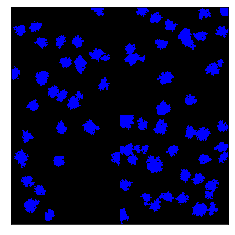

Loss =  7.996500910894597e-09
Map after episode#  0 . 87


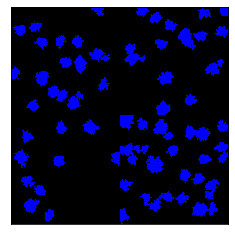

Loss =  8.755138244246687e-09
Map after episode#  0 . 88


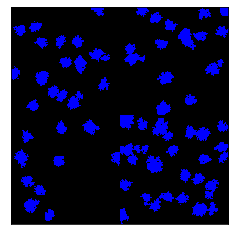

Loss =  8.512406941735698e-09
Map after episode#  0 . 89


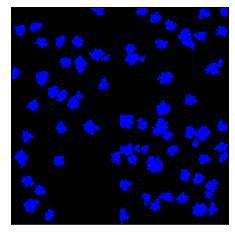

Loss =  7.787321247846979e-09
Map after episode#  0 . 90


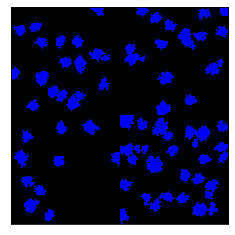

Loss =  7.30613005519922e-09
Map after episode#  0 . 91


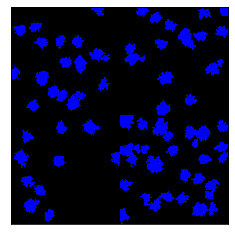

Loss =  7.250586108983356e-09
Map after episode#  0 . 92


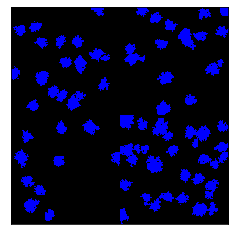

Loss =  6.333723474637337e-09
Map after episode#  0 . 93


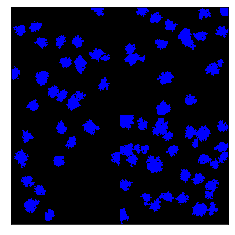

Loss =  6.35979383100943e-09
Map after episode#  0 . 94


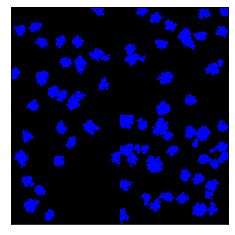

Loss =  7.277364124937429e-09
Map after episode#  0 . 95


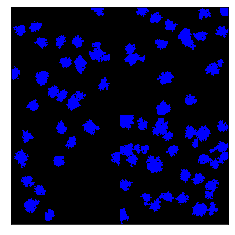

Loss =  7.462614293478025e-09
Map after episode#  0 . 96


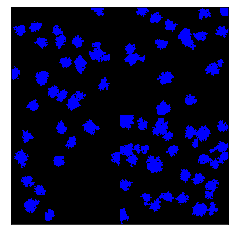

Loss =  6.083840743068759e-09
Map after episode#  0 . 97


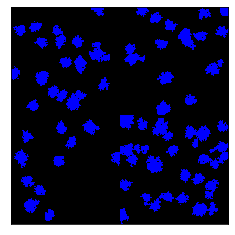

Loss =  7.104907085774737e-09
Map after episode#  0 . 98


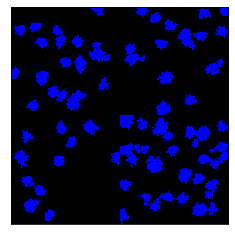

Loss =  6.260182813007743e-09
Map after episode#  0 . 99


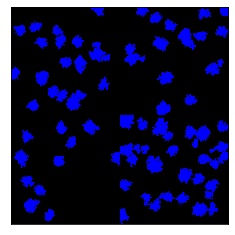

Loss =  7.098817625061127e-09
Map after episode#  0 . 100


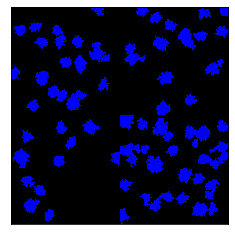

Loss =  6.908157336302387e-09
Map after episode#  0 . 101


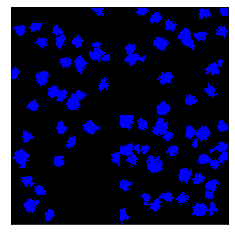

Loss =  6.150709745404882e-09
Map after episode#  0 . 102


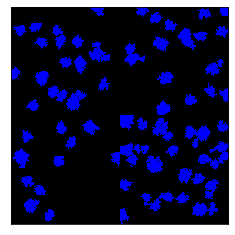

Loss =  6.381481550420231e-09
Map after episode#  0 . 103


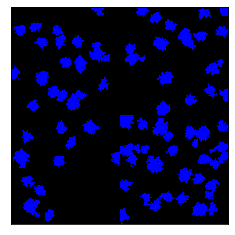

Loss =  5.8912719647730084e-09
Map after episode#  0 . 104


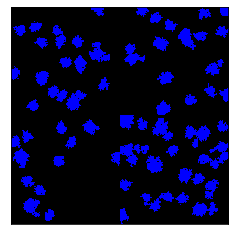

Loss =  6.802403438065898e-09
Map after episode#  0 . 105


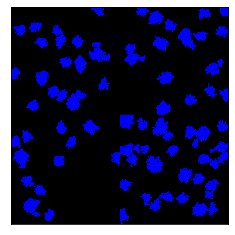

Loss =  5.626060323026275e-09
Map after episode#  0 . 106


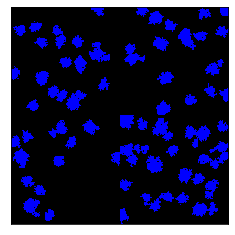

Loss =  5.677912317757141e-06
Map after episode#  0 . 107


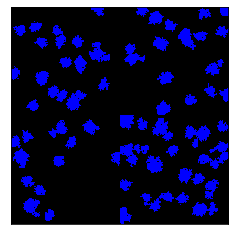

Loss =  4.883311619700244e-06
Map after episode#  0 . 108


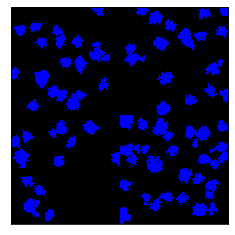

Loss =  4.86699490881988e-06
Map after episode#  0 . 109


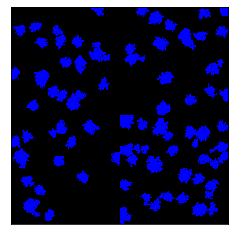

Loss =  2.843983276758818e-06
Map after episode#  0 . 110


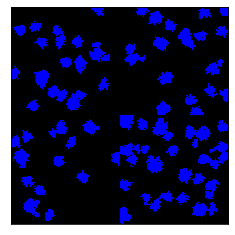

Loss =  5.613446221804394e-06
Map after episode#  0 . 111


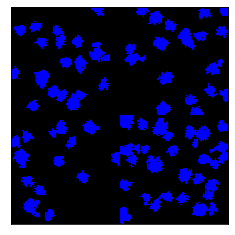

Loss =  1.2107795202474771e-06
Map after episode#  0 . 112


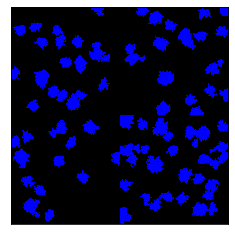

Loss =  3.1674447266826597e-09
Map after episode#  0 . 113


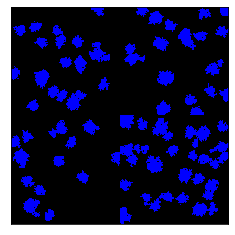

Loss =  2.8536751004075417e-09
Map after episode#  0 . 114


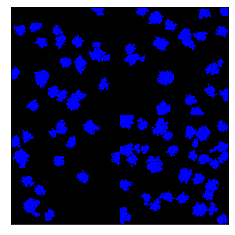

Loss =  4.816893210543134e-06
Map after episode#  0 . 115


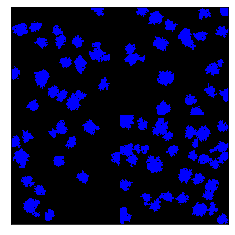

Loss =  1.1591735899626124e-05
Map after episode#  0 . 116


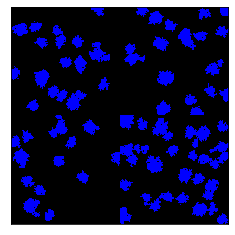

Loss =  1.1196866770041598e-05
Map after episode#  0 . 117


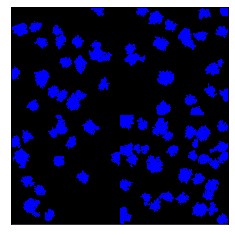

Loss =  9.179346231869756e-06
Map after episode#  0 . 118


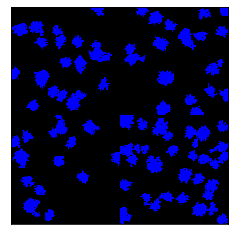

Loss =  1.0815106756480084e-05
Map after episode#  0 . 119


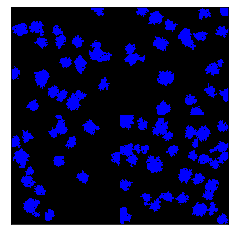

Loss =  4.403878781783133e-06
Map after episode#  0 . 120


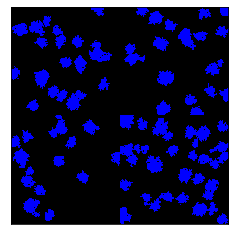

Loss =  1.5865530169227107e-06
Map after episode#  0 . 121


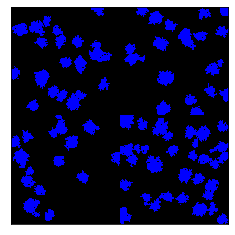

Loss =  2.295468637538974e-09
Map after episode#  0 . 122


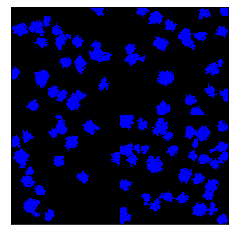

Loss =  2.193912190591473e-09
Map after episode#  0 . 123


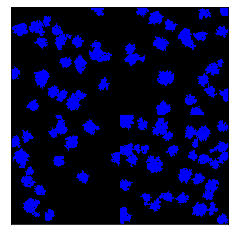

Loss =  2.229043626739496e-09
Map after episode#  0 . 124


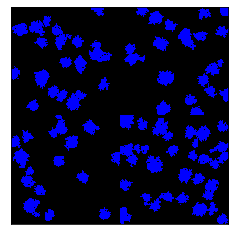

Loss =  2.299645337452753e-09
Map after episode#  0 . 125


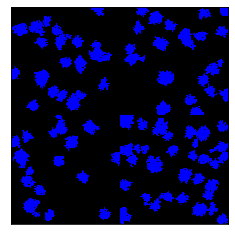

Loss =  2.2352893941969205e-09
Map after episode#  0 . 126


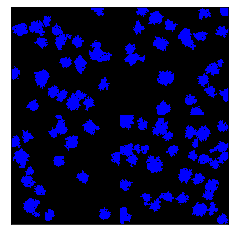

Loss =  2.160694580837028e-09
Map after episode#  0 . 127


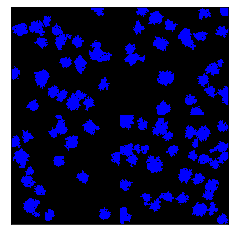

Loss =  2.8078301361552447e-06
Map after episode#  0 . 128


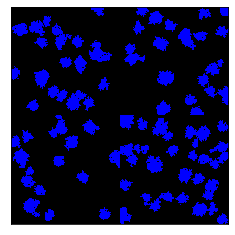

Loss =  5.2139134552595796e-06
Map after episode#  0 . 129


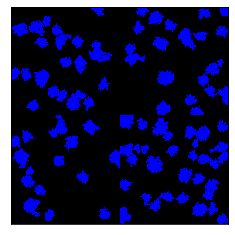

Loss =  3.6220395139151847e-06
Map after episode#  0 . 130


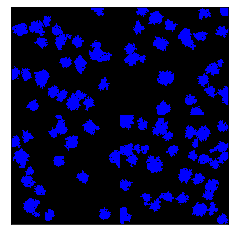

Loss =  3.6102168358814788e-06
Map after episode#  0 . 131


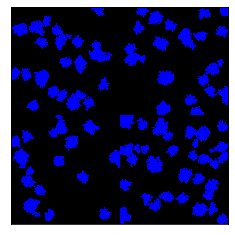

Loss =  4.410039446801719e-06
Map after episode#  0 . 132


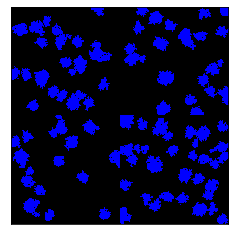

Loss =  1.2064841546563405e-06
Map after episode#  0 . 133


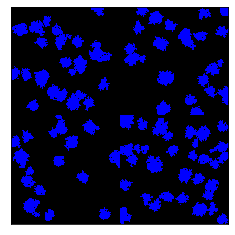

Loss =  0.0
Map after episode#  0 . 134


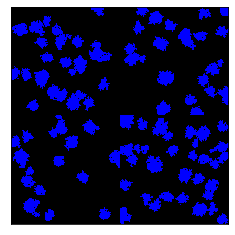

Loss =  0.0
Map after episode#  0 . 135


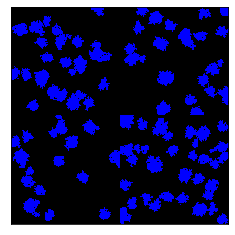

Loss =  5.935101070176517e-09
Map after episode#  0 . 136


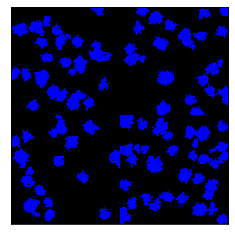

Loss =  2.450315153871254e-09
Map after episode#  0 . 137


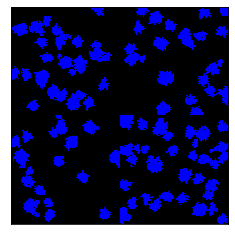

Loss =  2.0948662403859154e-09
Map after episode#  0 . 138


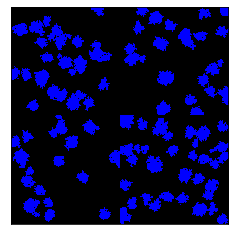

Loss =  2.3877889776163824e-09
Map after episode#  0 . 139


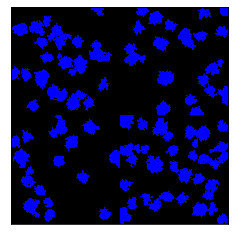

Loss =  2.242789319120323e-09
Map after episode#  0 . 140


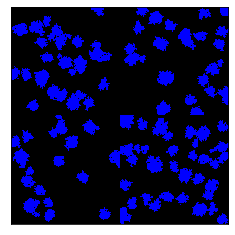

Loss =  2.07542555046601e-09
Map after episode#  0 . 141


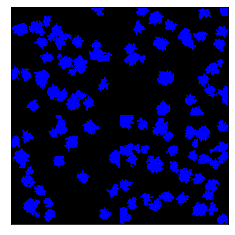

Loss =  2.1573854017250247e-09
Map after episode#  0 . 142


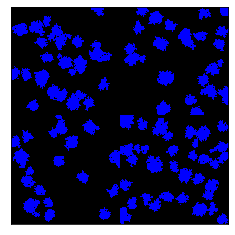

Loss =  2.326281487986693e-09
Map after episode#  0 . 143


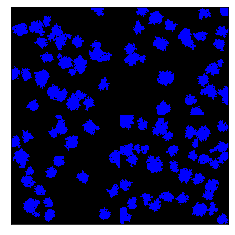

Loss =  2.329366561309942e-09
Map after episode#  0 . 144


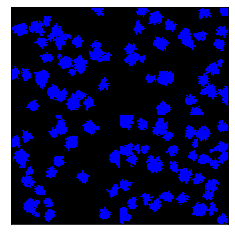

Loss =  2.1212255776815466e-09
Map after episode#  0 . 145


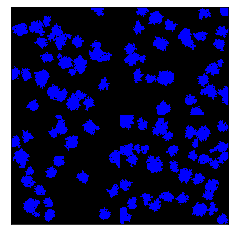

Loss =  2.332450509538828e-09
Map after episode#  0 . 146


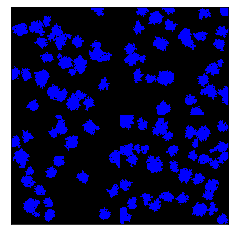

Loss =  2.681659160662171e-09
Map after episode#  0 . 147


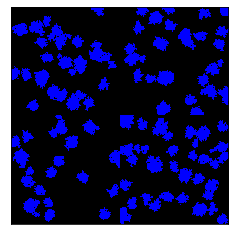

Loss =  2.213261351663473e-09
Map after episode#  0 . 148


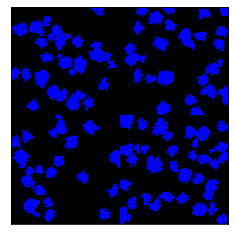

Loss =  1.8475379878767071e-09
Map after episode#  0 . 149


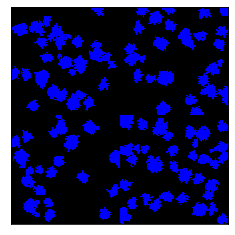

Loss =  2.4030280293432792e-09
Map after episode#  0 . 150


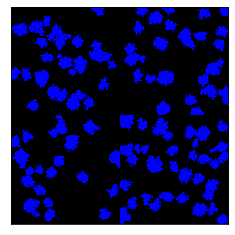

Loss =  2.1055424543303618e-09
Map after episode#  0 . 151


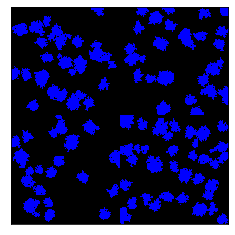

Loss =  2.295921886167873e-09
Map after episode#  0 . 152


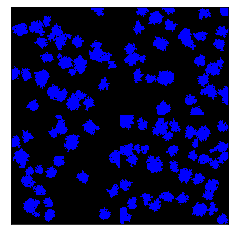

Loss =  2.125913062987133e-09
Map after episode#  0 . 153


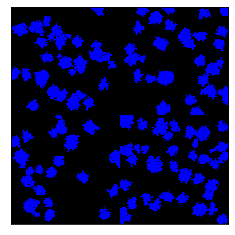

Loss =  2.1677025132634034e-09
Map after episode#  0 . 154


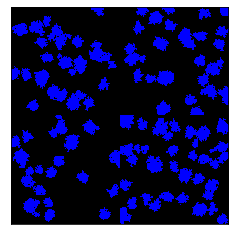

Loss =  2.0745120807792123e-09
Map after episode#  0 . 155


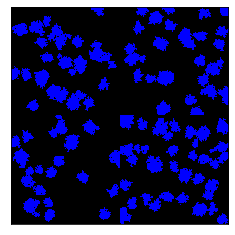

Loss =  2.0060826103687943e-06
Map after episode#  0 . 156


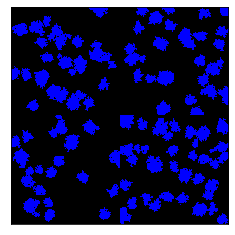

Loss =  1.4290819091243023e-05
Map after episode#  0 . 157


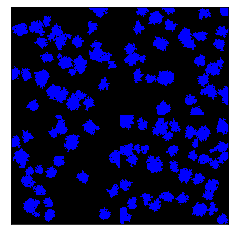

Loss =  5.966317366103904e-06
Map after episode#  0 . 158


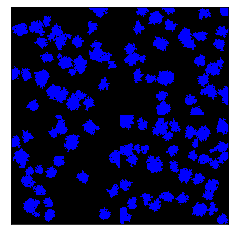

Loss =  8.773296466886993e-06
Map after episode#  0 . 159


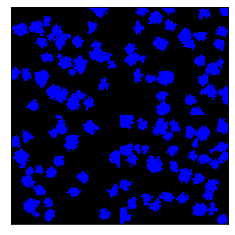

Loss =  1.309880499559926e-05
Map after episode#  0 . 160


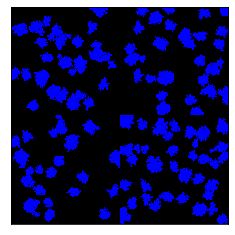

Loss =  7.5464395452308775e-06
Map after episode#  0 . 161


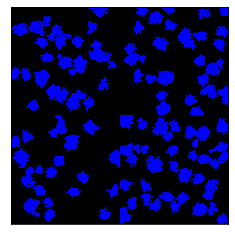

Loss =  0.0
Map after episode#  0 . 162


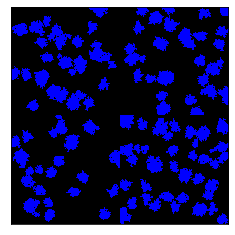

Loss =  3.5900106484431753e-06
Map after episode#  0 . 163


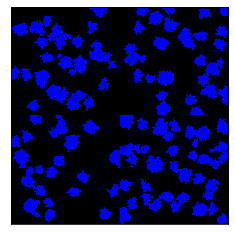

Loss =  8.751250864203857e-06
Map after episode#  0 . 164


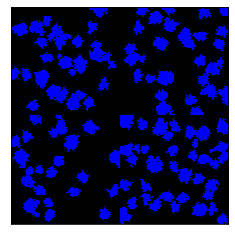

Loss =  8.349637712212595e-06
Map after episode#  0 . 165


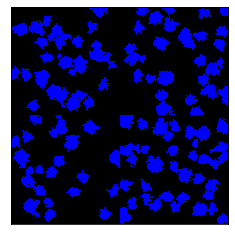

Loss =  8.335560639956459e-06
Map after episode#  0 . 166


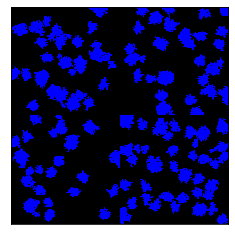

Loss =  1.1103152661304793e-05
Map after episode#  0 . 167


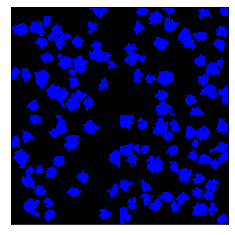

Loss =  4.77150849085311e-06
Map after episode#  0 . 168


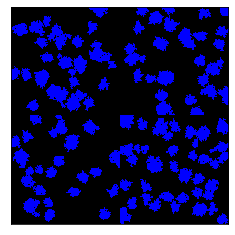

Loss =  0.0
Map after episode#  0 . 169


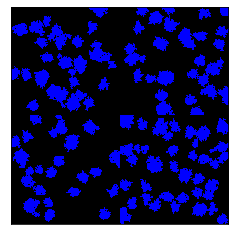

Loss =  0.0
Map after episode#  0 . 170


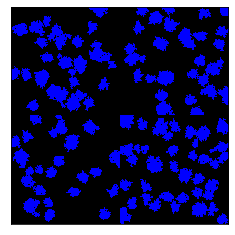

Loss =  0.0
Map after episode#  0 . 171


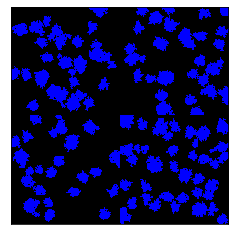

Loss =  2.006130385721796e-06
Map after episode#  0 . 172


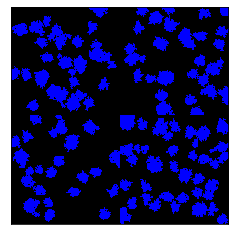

Loss =  9.128326981840323e-06
Map after episode#  0 . 173


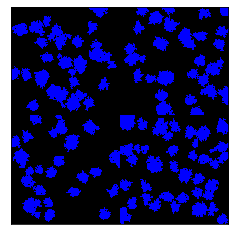

Loss =  9.525146291690233e-06
Map after episode#  0 . 174


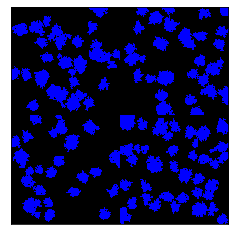

Loss =  9.128102433858543e-06
Map after episode#  0 . 175


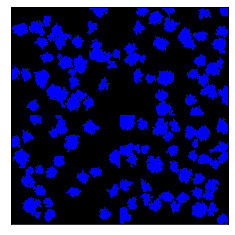

Loss =  6.342123110856681e-06
Map after episode#  0 . 176


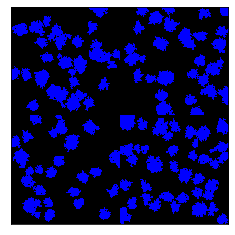

Loss =  6.355491212376438e-06
Map after episode#  0 . 177


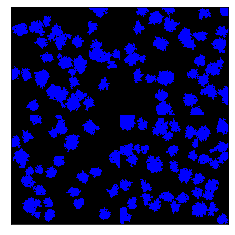

Loss =  1.693530287147468e-09
Map after episode#  0 . 178


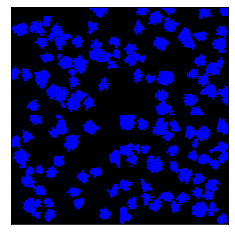

Loss =  1.6768194355363241e-09
Map after episode#  0 . 179


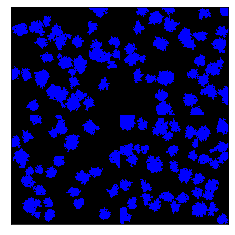

Loss =  1.6514222872829856e-09
Map after episode#  0 . 180


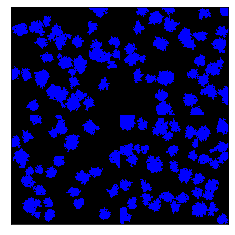

Loss =  1.8166585697799626e-09
Map after episode#  0 . 181


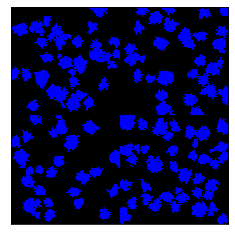

Loss =  1.9799710764295096e-09
Map after episode#  0 . 182


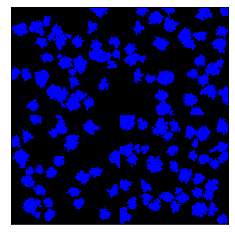

Loss =  1.5681253990354413e-09
Map after episode#  0 . 183


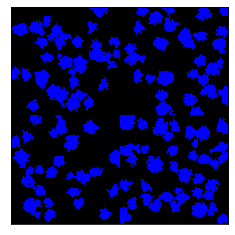

Loss =  1.670075001127752e-09
Map after episode#  0 . 184


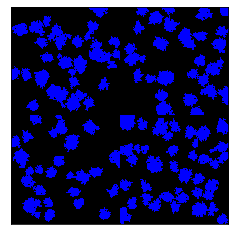

Loss =  1.7303900134586532e-09
Map after episode#  0 . 185


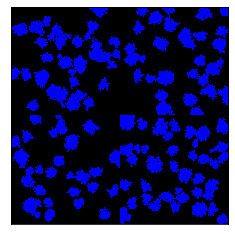

Loss =  1.6114796078820144e-09
Map after episode#  0 . 186


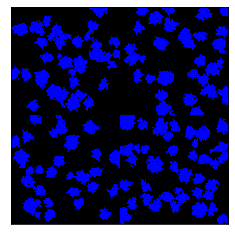

Loss =  1.6843457552281204e-09
Map after episode#  0 . 187


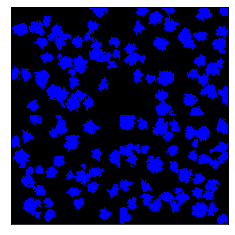

Loss =  1.4601965565454356e-09
Map after episode#  0 . 188


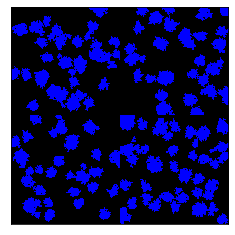

Loss =  1.8486443616018023e-09
Map after episode#  0 . 189


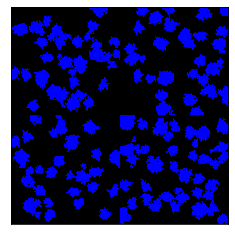

Loss =  1.4952597699395783e-09
Map after episode#  0 . 190


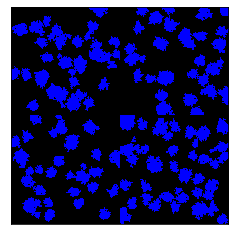

Loss =  1.4721082270477353e-09
Map after episode#  0 . 191


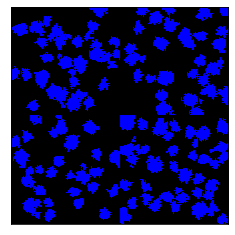

Loss =  1.9564462118719483e-09
Map after episode#  0 . 192


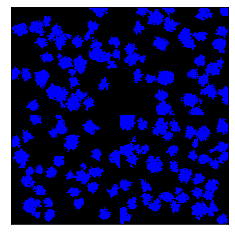

Loss =  1.4330058211349344e-09
Map after episode#  0 . 193


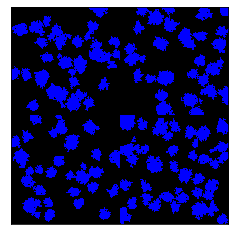

Loss =  1.6029439231978146e-09
Map after episode#  0 . 194


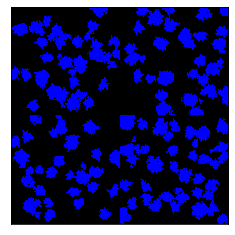

Loss =  1.6521062505485275e-09
Map after episode#  0 . 195


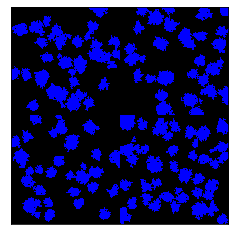

Loss =  1.6426876633865725e-09
Map after episode#  0 . 196


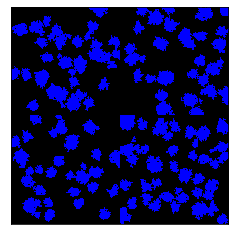

Loss =  1.692693819180173e-09
Map after episode#  0 . 197


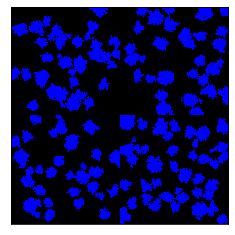

Loss =  1.929573036275175e-09
Map after episode#  0 . 198


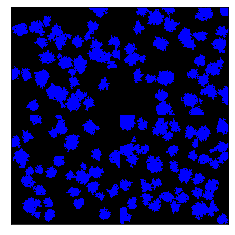

Loss =  1.6796244528022917e-09
Map after episode#  0 . 199


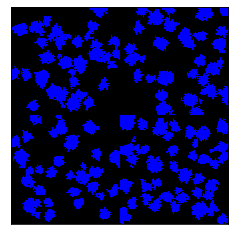

Loss =  4.778729273100596e-06
Map after episode#  0 . 200


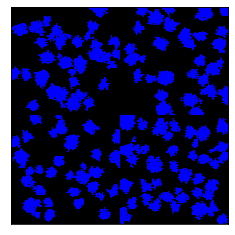

Loss =  4.394352056339796e-06
Map after episode#  0 . 201


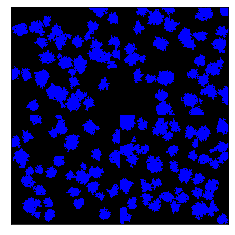

In [0]:
env = GridEnv('1000map.txt',1)
nrow = env.nrows
ncol = env.ncols

agent = SimpleAgent(3,env.goal)

n_epis = 10000
max_len = 10000
learn_steps = 500


STORE_PATH = '/content/drive/My Drive/Planning Project/GridWorld-Deterministic-Model-DQN'
files = glob.glob('/content/drive/My Drive/Planning Project/GridWorld-Deterministic-Model-DQN/*.npy')
start = max([int(re.findall('[0-9]+',t)[0]) for t in os.listdir('/content/drive/My Drive/Planning Project/GridWorld-Deterministic-Model-DQN')])


# train_writer = tf.summary.create_file_writer(STORE_PATH+f"/DoubleQ_{dt.datetime.now().strftime('%d%m%Y%H%M')}")
double_q = False

SWAP_STEPS = 100
ebuff = exp_buff(50000)
step_counter = 0



print('Planning and Learning-----DQN-----1000X1000 gridworld-----deterministic')

plot_rwds = []
for episode in range(start,n_epis,learn_steps):
  for step in range(0,learn_steps):
    avg_loss = 0
    env.reset()
    epi_len  = 0
    while True:
        state = env.curr_state
        agent.model[state[0], state[1]] = 1
        # print(episode,state)
        sensorRes = env.sense(agent.senseCap)
        for i,x in enumerate(sensorRes):
          if i == 0:
            agent.model[state[0]-x.shape[0]:state[0],state[1]] = np.flip(x)
            for t in range(0,len(x)):
              agent.comps.union(string(state),string([state[0]-t-1,state[1]]))
            if(len(x) != agent.senseCap):
              agent.model[state[0]-x.shape[0]-1,state[1]] = 0
          elif i == 1:
            agent.model[state[0]+1:state[0]+x.shape[0]+1,state[1]] = x
            for t in range(0,len(x)):
              agent.comps.union(string(state),string([state[0]+t+1,state[1]]))
            if(len(x) != agent.senseCap):
              agent.model[state[0]+x.shape[0]+1,state[1]] = 0
          elif i == 2:
            agent.model[state[0], state[1]-x.shape[0]:state[1]] = np.flip(x)
            for t in range(0,len(x)):
              agent.comps.union(string(state),string([state[0],state[1]-t-1]))
            if(len(x) != agent.senseCap):
              agent.model[state[0],state[1]-x.shape[0]-1] = 0
          else:
            agent.model[state[0], state[1]+1:state[1]+x.shape[0]+1] = x
            for t in range(0,len(x)):
              agent.comps.union(string(state),string([state[0],state[1]+t+1]))
            if(len(x) != agent.senseCap):
              if state[1]+x.shape[0]+1 < ncol:
                agent.model[state[0],state[1]+x.shape[0]+1] = 0

        action = agent.pick_action(string(state),sensorRes)
        # print(action)

        done = False

        for j in action:
          next_state, rwd, done = env.transition(j)
          agent.comps.union(string(state),string(next_state))
          norm_state = np.array([state[0]/nrow, state[1]/ncol])
          norm_next_state = np.array([next_state[0]/nrow, next_state[1]/ncol])
          ebuff.add((norm_state,agent.actrev[j],rwd,norm_next_state, done))
          
          step_counter += 1
          epi_len += 1

          if step_counter % SWAP_STEPS == 0:
            double_q = True
          else:
            double_q = False

          loss = agent.train(ebuff, double_q)
          avg_loss += loss
          state = next_state
            
          if done or epi_len > max_len:
            avg_loss /= epi_len
            print('Loss = ', avg_loss)
            break
        
        # print('Step# ',step,'Epi_len=',epi_len)

        if done or epi_len > max_len:
          break
        
    print('Map after episode# ', episode,'.',step)
    printgrid(agent.model)


  env.start = np.array([998,1])
  env.curr_state = env.start
  env.End = False
  epi_len = 0
  epi_rwd = 0
  while True:
        state = env.curr_state
        # print(episode,state)
        sensorRes = env.sense(agent.senseCap)
        action = agent.pick_action(string(state),sensorRes)
        done = False
        for j in action:
          next_state, rwd, done = env.transition(j)
          epi_rwd += rwd

          # agent.learn(string(state),action,rwd,string(next_state))

          state = next_state
          epi_len += 1
              
          if done:
              plot_rwds.append(epi_rwd)
              break
        if done:
          break
  printgrid(agent.model)

  print('Episode# ', episode, ' , Episode stats: ', epi_rwd, '/' , epi_len)

NameError: ignored

In [0]:
x,_ = matfromfile('1000map.txt')

In [0]:
x.shape

(1000, 1000)

In [0]:
v = [np.array([1]), np.array([2])]
v[np.random.randint(0,len(v))]

In [0]:
def proc(rews,k = 5):
    prews = []
    for i in range(0,len(rews),k):
        prews.append(sum(rews[i:i+k])/k)
    return prews

In [0]:
np.save('/content/drive/My Drive/Planning Project/plots/GridWorld-Deterministic-Model_50map.npy',plot_rwds)

In [0]:
rs = proc(plot_rwds,1)
plt.plot(rs,'r-')
plt.xlabel('Time')
plt.ylabel('Average Reward')

NameError: ignored

In [0]:
env.curr_state = np.array([1,1])
env.sense(3)

In [0]:
import numpy as np
plot_rwds = np.load('/content/drive/My Drive/Planning Project/plots/GridWorld-Deterministic-Model_50map.npy')
len(d)

2000

In [0]:
primary_network = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal(), input_shape = (2,)),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(num_actions)
])
primary_network.compile(optimizer=keras.optimizers.Adam(), loss='mse')

In [0]:
primary_network(np.array([1.,3.]).reshape(1,-1))

<tf.Tensor 'sequential_59_1/dense_179/BiasAdd:0' shape=(1, 4) dtype=float32>